# Modelo de deep learning baseado na memória de curto prazo (LSTM)

In [1]:
# Importando bibliotecas 
import math
from pandas_datareader import data as pdr
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pathlib import Path
import os
pd.options.mode.chained_assignment = None

#pip install tensorflow

In [2]:
# Diretório onde o script está localizado
base_diretório = Path(os.getcwd())
base_diretório = base_diretório.parent
caminho = base_diretório / 'Bases' / 'Bitcoin Historical Data.csv'

# Ler arquivo da base
acao = pd.read_csv(caminho)

# Formatar data
acao['Date'] = pd.to_datetime(acao['Date'], format='%m/%d/%Y')

# Filtrar a data em que vamos puxar os dados
acao = acao[acao['Date'].dt.year >= 2023]

# Converter as colunas referentes a dinheiro para float
colunas_dinheiro = ['Price', 'Open', 'High', 'Low']
for coluna in colunas_dinheiro:
    if acao[coluna].dtype == 'object':  
        acao[coluna] = pd.to_numeric(acao[coluna].str.replace(',', ''))

# Converter a coluna 'Change %' para float
if acao['Change %'].dtype == 'object':  
    acao['Change %'] = pd.to_numeric(acao['Change %'].str.replace('%', ''))

def converter_vol_para_numero(valor):
    if 'K' in valor:
        return float(valor.replace('K', '').replace(',', '')) * 1000
    elif 'M' in valor:
        return float(valor.replace('M', '').replace(',', '')) * 1000000
    elif 'B' in valor:
        return float(valor.replace('B', '').replace(',', '')) * 1000000000
    else:
        return float(valor.replace(',', ''))

# Aplicar a função na coluna 'Vol.'
acao['Vol.'] = acao['Vol.'].apply(converter_vol_para_numero)

# Ordenar data das bases
acao = acao.sort_values(by='Date', ascending=True)

acao = acao.rename(columns={'Vol.': 'Volume', 'Change %': 'Change'})

acao

,Date,Price,Open,High,Low,Volume,Change %
502,2023-01-01,16618.4,16537.5,16621.9,16499.7,107840.0,0.49
501,2023-01-02,16674.3,16618.4,16766.9,16551.0,136030.0,0.34
500,2023-01-03,16674.2,16673.1,16773.2,16607.2,178730.0,0.00
499,2023-01-04,16852.1,16674.2,16976.5,16656.5,247390.0,1.07
498,2023-01-05,16829.8,16852.2,16877.9,16772.3,178960.0,-0.13
...,...,...,...,...,...,...,...
4,2024-05-13,62937.2,61480.5,63443.2,60779.0,70550.0,2.37
3,2024-05-14,61569.4,62936.8,63102.6,61156.9,68840.0,-2.17
2,2024-05-15,66225.1,61569.4,66417.1,61357.5,106050.0,7.56
1,2024-05-16,65231.0,66219.6,66643.9,64623.3,72550.0,-1.50


In [3]:
#nao pode ser ajustados

cotacao = acao['Price'].to_numpy().reshape(-1, 1)

cotacao

array([[16618.4],
       [16674.3],
       [16674.2],
       [16852.1],
       [16829.8],
       [16950.9],
       [16943.6],
       [17119. ],
       [17180.1],
       [17439.1],
       [17942.3],
       [18851.3],
       [19927. ],
       [20958.2],
       [20879.8],
       [21184.2],
       [21137.1],
       [20670.6],
       [21081.2],
       [22677.2],
       [22775.7],
       [22707.8],
       [22915.5],
       [22632.5],
       [23055.1],
       [23016. ],
       [23074.6],
       [23027.9],
       [23753.1],
       [22832.2],
       [23125.1],
       [23725.6],
       [23427.6],
       [23431.2],
       [23323.8],
       [22936. ],
       [22761.8],
       [23251.7],
       [22964.6],
       [21792.5],
       [21635. ],
       [21859.8],
       [21786.8],
       [21772.6],
       [22198.5],
       [24327.9],
       [23539.6],
       [24573.5],
       [24631.4],
       [24302.9],
       [24839.5],
       [24450.7],
       [24186.6],
       [23936.3],
       [23191.5],
       [23

In [4]:
tamanho_dados_treinamento = int(len(cotacao) * 0.8)

tamanho_dados_treinamento

402

In [5]:
#escalar os dados entre 0 e 1, para deixar mais fácil o processamento
#dados em escala pré definidas são mais fáceis de lidar. 

escalador = MinMaxScaler(feature_range=(0, 1))

dados_entre_0_e_1_treinamento = escalador.fit_transform(cotacao[0: tamanho_dados_treinamento, :])

dados_entre_0_e_1_teste = escalador.transform(cotacao[tamanho_dados_treinamento: , :])

dados_entre_0_e_1 = list(dados_entre_0_e_1_treinamento.reshape(
    len(dados_entre_0_e_1_treinamento))) + list(dados_entre_0_e_1_teste.reshape(len(dados_entre_0_e_1_teste)))
                                                

dados_entre_0_e_1 = np.array(dados_entre_0_e_1).reshape(len(dados_entre_0_e_1), 1)

dados_entre_0_e_1

array([[0.00000000e+00],
       [1.84222148e-03],
       [1.83892591e-03],
       [7.70173808e-03],
       [6.96682683e-03],
       [1.09577574e-02],
       [1.07171811e-02],
       [1.64976041e-02],
       [1.85111950e-02],
       [2.70467114e-02],
       [4.36300002e-02],
       [7.35866965e-02],
       [1.09037101e-01],
       [1.43020980e-01],
       [1.40437256e-01],
       [1.50468959e-01],
       [1.48916747e-01],
       [1.33542931e-01],
       [1.47074526e-01],
       [1.99671762e-01],
       [2.02917894e-01],
       [2.00680205e-01],
       [2.07525096e-01],
       [1.98198644e-01],
       [2.12125706e-01],
       [2.10837140e-01],
       [2.12768341e-01],
       [2.11229312e-01],
       [2.35128758e-01],
       [2.04779889e-01],
       [2.14432602e-01],
       [2.34222477e-01],
       [2.24401690e-01],
       [2.24520330e-01],
       [2.20980892e-01],
       [2.08200687e-01],
       [2.02459811e-01],
       [2.18604789e-01],
       [2.09143219e-01],
       [1.70515888e-01],


In [6]:
dados_para_treinamento = dados_entre_0_e_1[0: tamanho_dados_treinamento, :]

#dados que serão usados para gerar o resultado
treinamento_x = []
#cotação que aconteceu de fato
treinamento_y = []


for i in range(60, len(dados_para_treinamento)):

    #60 ultimos dias
    treinamento_x.append(dados_para_treinamento[i - 60: i, 0])
    #cotacao
    treinamento_y.append(dados_para_treinamento[i, 0])

    if i <= 61:

        print(treinamento_x)
        print(treinamento_y)



[array([0.        , 0.00184222, 0.00183893, 0.00770174, 0.00696683,
       0.01095776, 0.01071718, 0.0164976 , 0.0185112 , 0.02704671,
       0.04363   , 0.0735867 , 0.1090371 , 0.14302098, 0.14043726,
       0.15046896, 0.14891675, 0.13354293, 0.14707453, 0.19967176,
       0.20291789, 0.2006802 , 0.2075251 , 0.19819864, 0.21212571,
       0.21083714, 0.21276834, 0.21122931, 0.23512876, 0.20477989,
       0.2144326 , 0.23422248, 0.22440169, 0.22452033, 0.22098089,
       0.20820069, 0.20245981, 0.21860479, 0.20914322, 0.17051589,
       0.16532537, 0.1727338 , 0.17032804, 0.16986007, 0.18389589,
       0.25407167, 0.22809272, 0.26216558, 0.26407372, 0.25324778,
       0.27093179, 0.25811863, 0.24941504, 0.24116623, 0.21662086,
       0.21578378, 0.22872218, 0.22659324, 0.21461056, 0.23147397])]
[0.2256474139692458]
[array([0.        , 0.00184222, 0.00183893, 0.00770174, 0.00696683,
       0.01095776, 0.01071718, 0.0164976 , 0.0185112 , 0.02704671,
       0.04363   , 0.0735867 , 0.1090

In [7]:
#transformando as listas em arrays e dando reshape 3d 

treinamento_x, treinamento_y = np.array(treinamento_x), np.array(treinamento_y)

print(treinamento_x)

treinamento_x = treinamento_x.reshape(treinamento_x.shape[0], treinamento_x.shape[1], 1)

print(treinamento_x)

[[0.         0.00184222 0.00183893 ... 0.22659324 0.21461056 0.23147397]
 [0.00184222 0.00183893 0.00770174 ... 0.21461056 0.23147397 0.22564741]
 [0.00183893 0.00770174 0.00696683 ... 0.23147397 0.22564741 0.18903367]
 ...
 [0.89500656 0.87897033 0.90816246 ... 0.87210567 0.87583955 0.86961093]
 [0.87897033 0.90816246 0.89309843 ... 0.87583955 0.86961093 0.85562784]
 [0.90816246 0.89309843 0.89549101 ... 0.86961093 0.85562784 0.8594441 ]]
[[[0.        ]
  [0.00184222]
  [0.00183893]
  ...
  [0.22659324]
  [0.21461056]
  [0.23147397]]

 [[0.00184222]
  [0.00183893]
  [0.00770174]
  ...
  [0.21461056]
  [0.23147397]
  [0.22564741]]

 [[0.00183893]
  [0.00770174]
  [0.00696683]
  ...
  [0.23147397]
  [0.22564741]
  [0.18903367]]

 ...

 [[0.89500656]
  [0.87897033]
  [0.90816246]
  ...
  [0.87210567]
  [0.87583955]
  [0.86961093]]

 [[0.87897033]
  [0.90816246]
  [0.89309843]
  ...
  [0.87583955]
  [0.86961093]
  [0.85562784]]

 [[0.90816246]
  [0.89309843]
  [0.89549101]
  ...
  [0.8696

In [8]:
#construindo o modelo

modelo = Sequential()

#vamos criar um modelo com 50 neurônios
#return sequences = True pois vamos usar outro LSTM depois.
#definir o shape, que no caso são 60 informações para gerar uma.
#Adicionar mais neurônios com o dense, 25 e 1
#Não se apegue a isso agora, é apenas um arquitetura de deep learning.

modelo.add(LSTM(50, return_sequences=True, input_shape = (treinamento_x.shape[1], 1)))
modelo.add(LSTM(50, return_sequences=False))
modelo.add(Dense(25))
modelo.add(Dense(1))

treinamento_x.shape[1]

c:\Users\yupopic\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60

In [9]:
#copilando o modelo

# a função de loss é a forma de medir o erro do modelo, que nesse caso
#é o classico erro médio quadrático da que é usado em regressão linear
#otimizador e medida de erro

modelo.compile(optimizer="adam", loss="mean_squared_error") 

In [10]:
#agora com o modelo copilado e os dados, podemos treinar o modelo
#batch size é depois de quantas em quantas amostras o modelo irá otimizar os parâmetros.
#epochs é quantas vezes o algoritmo irá rodar os dados treinamento, aprendendo. 

modelo.fit(treinamento_x, treinamento_y, batch_size=1, epochs=1)

342/342 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - loss: 0.0193


In [11]:
#criar dados de teste

dados_teste = dados_entre_0_e_1[tamanho_dados_treinamento - 60:, :]

teste_x = []
teste_y = cotacao[tamanho_dados_treinamento: , :] 

for i in range(60, len(dados_teste)):
    teste_x.append(dados_teste[i - 60: i, 0])
    

In [12]:
#reshape
teste_x = np.array(teste_x)
teste_x = teste_x.reshape(teste_x.shape[0], teste_x.shape[1], 1)

In [13]:
#pegando predições do modelo

predicoes = modelo.predict(teste_x)

#tirando a escala dos dados

predicoes = escalador.inverse_transform(predicoes)

predicoes

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


array([[44307.324],
       [44491.88 ],
       [44775.113],
       [45229.023],
       [45788.973],
       [46412.43 ],
       [47155.184],
       [47889.555],
       [48730.61 ],
       [49568.65 ],
       [50367.863],
       [51051.98 ],
       [51663.57 ],
       [52159.797],
       [52594.91 ],
       [52927.527],
       [53141.055],
       [53231.42 ],
       [53312.633],
       [53383.094],
       [53653.316],
       [54185.496],
       [55220.72 ],
       [56319.32 ],
       [57497.52 ],
       [58594.79 ],
       [59662.09 ],
       [61010.164],
       [62011.7  ],
       [62986.94 ],
       [63898.45 ],
       [64796.223],
       [65616.234],
       [66376.09 ],
       [67272.766],
       [68083.586],
       [68919.56 ],
       [69556.945],
       [69922.47 ],
       [69827.48 ],
       [69779.91 ],
       [69639.77 ],
       [69050.3  ],
       [68785.81 ],
       [68434.18 ],
       [67972.99 ],
       [67529.96 ],
       [67362.79 ],
       [67512.21 ],
       [67798.19 ],


In [14]:
#pegando o erro médio quadrático (RMSE)

rmse = np.sqrt(np.mean(predicoes - teste_y) ** 2)
rmse

12.470018564356609

In [15]:
#criando o grafico do modelo


treinamento = acao.iloc[:tamanho_dados_treinamento, :]
df_teste = pd.DataFrame({"Price": acao['Price'].iloc[tamanho_dados_treinamento:],
                        "predicoes": predicoes.reshape(len(predicoes))})


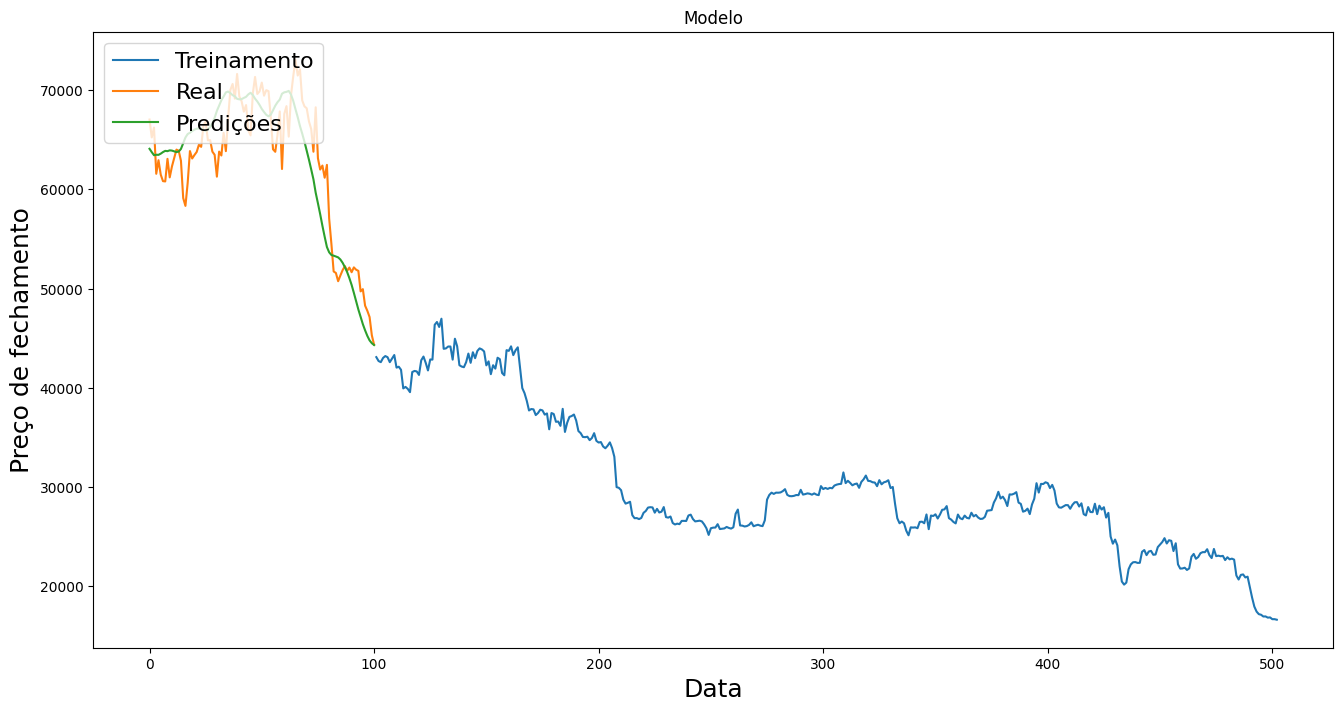

In [16]:
plt.figure(figsize =(16, 8))
plt.title('Modelo')
plt.xlabel('Data', fontsize = 18)
plt.ylabel("Preço de fechamento", fontsize = 18)
plt.plot(treinamento['Price'])
plt.plot(df_teste[['Price', 'predicoes']])
plt.legend(['Treinamento', 'Real', 'Predições'], loc=2, prop={'size': 16})
plt.show()

In [17]:
df_teste.sort_index()

df_teste

,Price,predicoes
100,44339.8,44307.324219
99,45293.3,44491.878906
98,47127.5,44775.113281
97,47758.2,45229.023438
96,48277.3,45788.972656
...,...,...
4,62937.2,63477.804688
3,61569.4,63486.789062
2,66225.1,63441.929688
1,65231.0,63749.910156


In [18]:
#o preço é legal, mas o importante é acertar pra qual mercado o lado vai. Sera q isso foi feito?

#calcular media de acertos e expectativa de lucro

df_teste['variacao_percentual_acao'] = df_teste['Price'].pct_change()
df_teste['variacao_percentual_modelo'] = df_teste['predicoes'].pct_change()

df_teste = df_teste.dropna()

df_teste['var_acao_maior_menor_que_zero'] = np.where(df_teste['variacao_percentual_acao'] > 0, 
                                                      True, False)
df_teste['var_modelo_maior_menor_que_zero'] = np.where(df_teste['variacao_percentual_modelo'] > 0, 
                                                      True, False)

df_teste['acertou_o_lado'] = np.where(df_teste['var_acao_maior_menor_que_zero'] == df_teste['var_modelo_maior_menor_que_zero']
                                      , True, False)

df_teste['variacao_percentual_acao_abs'] = df_teste['variacao_percentual_acao'].abs()

df_teste

,Price,predicoes,variacao_percentual_acao,variacao_percentual_modelo,var_acao_maior_menor_que_zero,var_modelo_maior_menor_que_zero,acertou_o_lado,variacao_percentual_acao_abs
99,45293.3,44491.878906,0.021504,0.004165,True,True,True,0.021504
98,47127.5,44775.113281,0.040496,0.006366,True,True,True,0.040496
97,47758.2,45229.023438,0.013383,0.010138,True,True,True,0.013383
96,48277.3,45788.972656,0.010869,0.012380,True,True,True,0.010869
95,49941.3,46412.429688,0.034468,0.013616,True,True,True,0.034468
...,...,...,...,...,...,...,...,...
4,62937.2,63477.804688,0.023702,-0.001899,True,False,False,0.023702
3,61569.4,63486.789062,-0.021733,0.000142,False,True,False,0.021733
2,66225.1,63441.929688,0.075617,-0.000707,True,False,False,0.075617
1,65231.0,63749.910156,-0.015011,0.004855,False,True,False,0.015011


In [19]:
acertou_lado = df_teste['acertou_o_lado'].sum()/len(df_teste['acertou_o_lado'])
errou_lado = 1 - acertou_lado

media_lucro = df_teste.groupby('acertou_o_lado')['variacao_percentual_acao_abs'].mean()

exp_mat_lucro = acertou_lado * media_lucro[1] - media_lucro[0] * errou_lado

ganho_sobre_perda = media_lucro[1]/media_lucro[0]

print(media_lucro)
print(ganho_sobre_perda)
print(acertou_lado)
print(exp_mat_lucro * 100)

acertou_o_lado
False    0.023761
True     0.026028
Name: variacao_percentual_acao_abs, dtype: float64
1.0953847822415896
0.46
-0.08583217064249155


C:\Users\yupopic\AppData\Local\Temp\ipykernel_36264\1543314228.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  exp_mat_lucro = acertou_lado * media_lucro[1] - media_lucro[0] * errou_lado
C:\Users\yupopic\AppData\Local\Temp\ipykernel_36264\1543314228.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ganho_sobre_perda = media_lucro[1]/media_lucro[0]


In [20]:
#criando um código que você passa 60 dias e ele devolve a cotação
#resumindo: vamos descobrir o preço da petrobras de hoje/amanha com esse modelo

data_hoje = datetime.now()

#se quiser escolher um dia, basta fazer assim

#data_hoje = datetime.now() - timedelta(days = 1)

if data_hoje.hour > 18:
    
    final = data_hoje
    inicial = datetime.now() - timedelta(days = 252)
    
else:
    final = data_hoje - timedelta(days = 1)
    inicial = datetime.now() - timedelta(days = 252)
    
#nao vai botar outra ação aqui hein kkkkkkkk
# cotacoes = pdr.get_data_yahoo(acao, inicial, final) 
ultimos_60_dias = acao['Price'].iloc[-60:].values.reshape(-1, 1)

ultimos_60_dias_escalado = escalador.transform(ultimos_60_dias)

teste_x = []
teste_x.append(ultimos_60_dias_escalado)
teste_x = np.array(teste_x)
teste_x = teste_x.reshape(teste_x.shape[0], teste_x.shape[1], 1)

previsao_de_preco = modelo.predict(teste_x)
previsao_de_preco = escalador.inverse_transform(previsao_de_preco)

print(previsao_de_preco)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
[[64579.79]]


# Sugestões:
<br>

- Melhorar as estatísticas de avaliação (dias seguidos ganhando, max DD, etc)
<br>

- Rodar pra todas as ações do ibovespa e criar uma expectativa matemática da expectativa matemática. Isso vai deixar o resultado final ainda mais robusto, definando a aloção do $ basedo na liquidez
